In [ ]:
from fastai.vision.all import *

In [ ]:
src = untar_data(URLs.PLANET_SAMPLE)
df = pd.read_csv(src/'labels.csv')

In [ ]:
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [ ]:
all_tags = df["tags"].values
all_labels = []
for row in all_tags:
    all_labels += row.split(" ")
len(all_labels)

2899

In [ ]:
different_labels = set(all_labels)
len(different_labels)

17

In [ ]:
counts = {
    label: all_labels.count(label) 
    for label in different_labels
}

counts = {
    key: value 
    for key, value in 
    sorted(
        counts.items(), 
        key = lambda item: -item[1]
    )
}

In [ ]:
counts

{'primary': 934,
 'clear': 701,
 'agriculture': 318,
 'road': 209,
 'partly_cloudy': 194,
 'water': 169,
 'cultivation': 124,
 'habitation': 93,
 'haze': 55,
 'cloudy': 50,
 'bare_ground': 19,
 'blooming': 9,
 'selective_logging': 8,
 'artisinal_mine': 7,
 'slash_burn': 6,
 'conventional_mine': 2,
 'blow_down': 1}

In [ ]:
len(df)

1000

In [ ]:
for key, count in counts.items():
    if count < 10:
        df = df[df["tags"].str.contains(key) == False]

In [ ]:
len(df)

968

In [ ]:
df["image_name"].head(), src.ls()

(0    train_21983
 1     train_9516
 2    train_12664
 3    train_36960
 4     train_5302
 Name: image_name, dtype: object,
 (#2) [Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/labels.csv'),Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train')])

In [ ]:
(src/'train').ls()[:3]

(#3) [Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train/train_12787.jpg'),Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train/train_33759.jpg'),Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train/train_7519.jpg')]

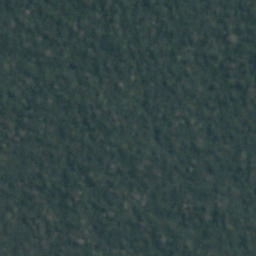

In [ ]:
PILImage.create((src/'train'/'train_2407.jpg'))

In [ ]:
def get_x(row:pd.Series) -> Path:
    return (src/'train'/row.image_name).with_suffix(".jpg")

In [ ]:
def get_y(row:pd.Series) -> List[str]:
    return row.tags.split(" ")

In [ ]:
row = df.iloc[0]
get_x(row), get_y(row)

(Path('/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train/train_21983.jpg'),
 ['partly_cloudy', 'primary'])

In [ ]:
get_x = ColReader(0, pref=f'{src}/train/', suff=".jpg")
get_y = ColReader(1, label_delim=" ")

In [ ]:
tfms = [
    [get_x, PILImage.create], 
    [
        get_y,
        MultiCategorize(vocab=different_labels), 
        OneHotEncode(len(different_labels))
    ]
]

In [ ]:
train_idxs, valid_idxs = (
    RandomSplitter(valid_pct=0.2, seed=42)(df)
)

In [ ]:
train_idxs, valid_idxs

((#775) [888,918,313,104,751,504,661,774,492,634...],
 (#193) [622,943,48,152,686,547,418,768,558,863...])

In [ ]:
dsets = Datasets(df, tfms=tfms, splits=[train_idxs, valid_idxs])

In [ ]:
dsets.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

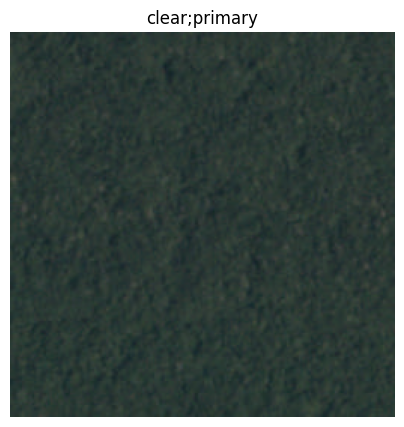

In [ ]:
show_at(dsets.train, 0);

In [ ]:
batch_tfms = [
    IntToFloatTensor(), 
    *aug_transforms(
        flip_vert=True, 
        max_lighting=0.1, 
        max_zoom=1.05, 
        max_warp=0.
    ), 
    Normalize.from_stats(*imagenet_stats)
]

In [ ]:
dls = dsets.dataloaders(
    after_item=[ToTensor], 
    after_batch=batch_tfms
)

In [ ]:
dls.device

device(type='cuda', index=0)

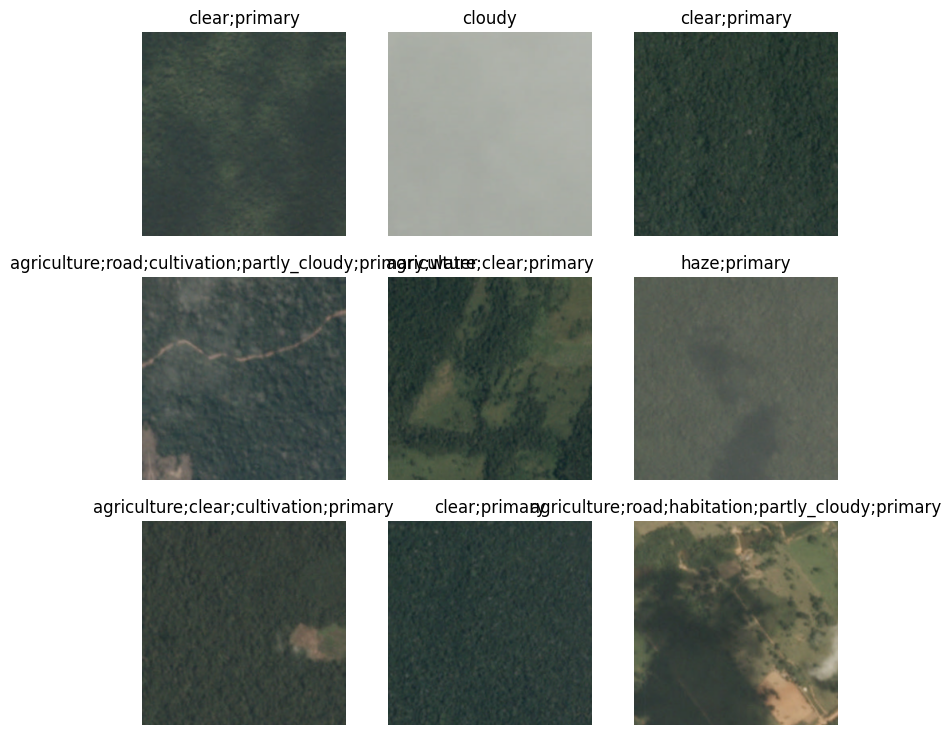

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])

In [ ]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=17, bias=False)
)

In [ ]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
t = tensor([[0.1, 0.5, 0.3, 0.7, 0.2]])
torch.sigmoid(t)

tensor([[0.5250, 0.6225, 0.5744, 0.6682, 0.5498]])

In [ ]:
learn.loss_func.thresh

0.5

SuggestedLRs(valley=0.002511886414140463)

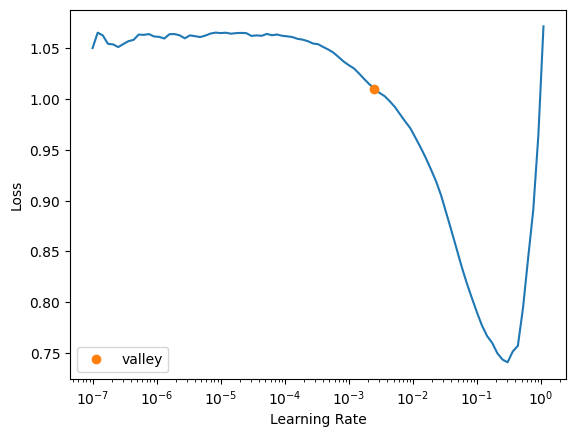

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, slice(2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.957430,0.729192,0.603170,00:05


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/2.6**4, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.852019,0.676423,0.644925,00:08
1,0.779269,0.730228,0.687900,00:08
2,0.711121,0.519590,0.793051,00:08
3,0.649912,0.406981,0.901250,00:08
4,0.597333,0.384169,0.919537,00:08


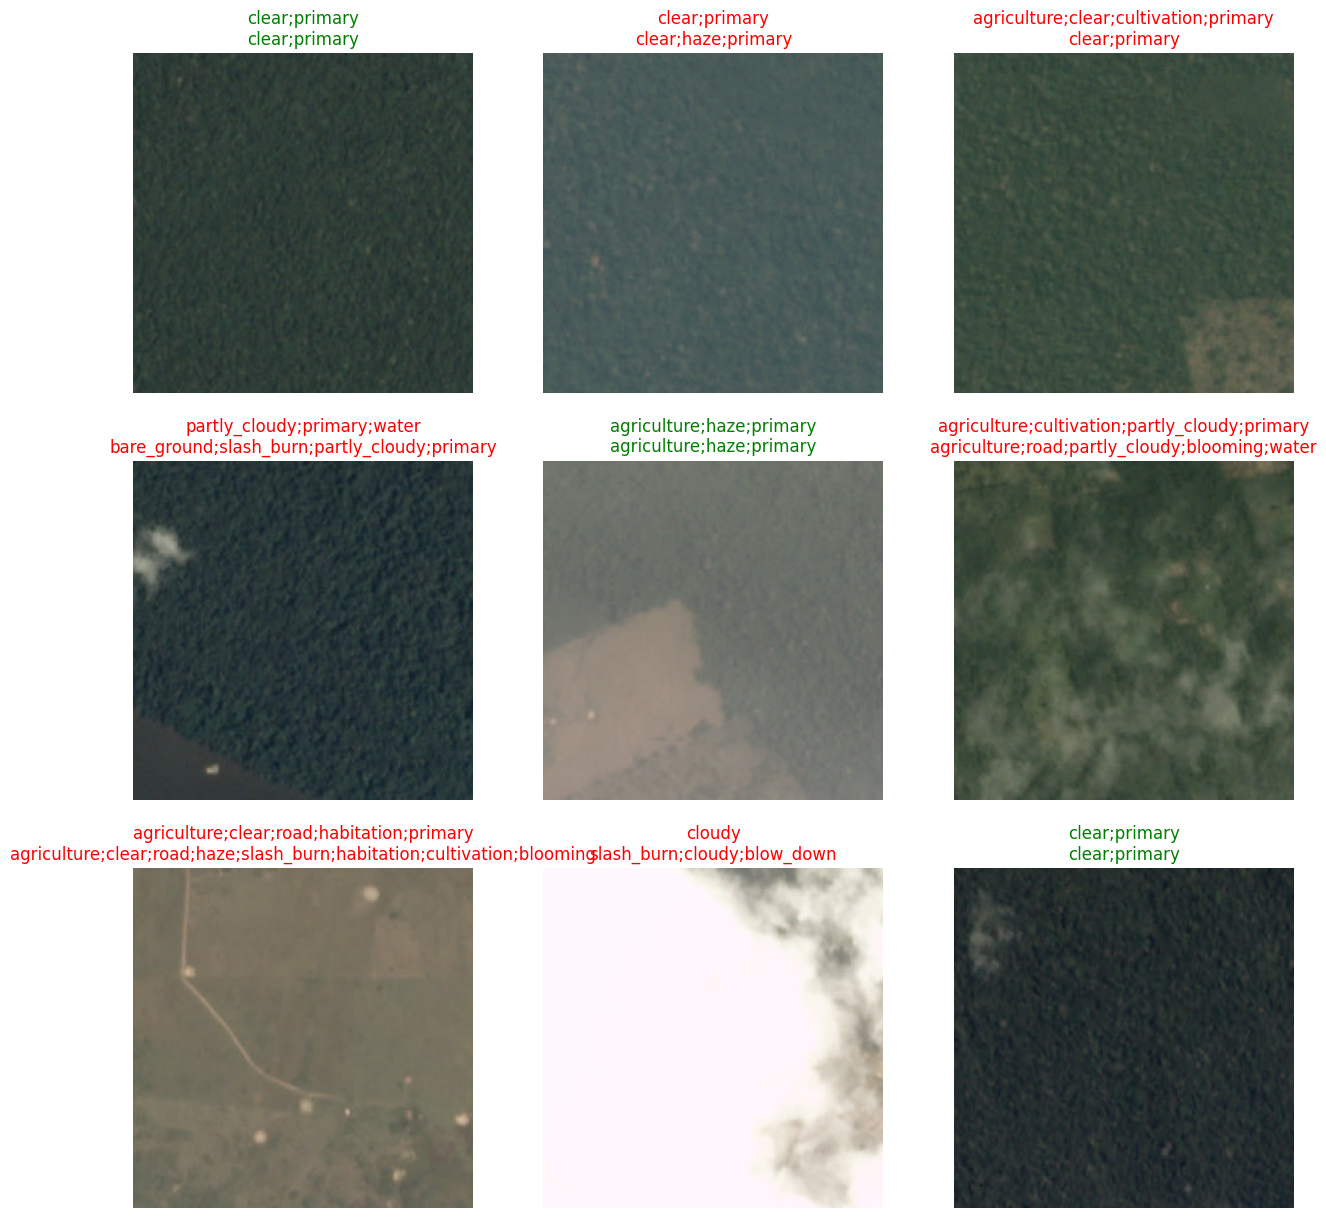

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
model = learn.model
fname = get_x(df.iloc[0])

In [ ]:
fname

'/home/zach_mueller_huggingface_co/.fastai/data/planet_sample/train/train_21983.jpg'

In [ ]:
im = Image.open(fname)
im = im.convert("RGB")
t_im = tensor(im)
t_im = t_im.permute(2,0,1).type(torch.uint8)

In [ ]:
t_im = t_im.unsqueeze(0)
t_im = t_im.float().div_(255.)

In [ ]:
mean, std = (
    [0.485, 0.456, 0.406], 
    [0.229, 0.224, 0.225]
)
vector = [1]*4
vector[1] = -1
mean = tensor(mean).view(*vector)
std = tensor(std).view(*vector)

In [ ]:
mean.shape, std.shape

(torch.Size([1, 3, 1, 1]), torch.Size([1, 3, 1, 1]))

In [ ]:
t_im = (t_im - mean) / std

In [ ]:
t_im.shape

torch.Size([1, 3, 256, 256])

In [ ]:
with torch.inference_mode():
    model.eval()
    preds = model(t_im.cuda())

In [ ]:
preds.shape

torch.Size([1, 17])

In [ ]:
decoded_preds = torch.sigmoid(preds) > 0.5

In [ ]:
decoded_preds

tensor([[False, False, False, False, False, False, False, False, False, False,
         False,  True, False,  True, False, False, False]], device='cuda:0')

In [ ]:
from itertools import compress

In [ ]:
present_labels = list(compress(
        data=list(different_labels), selectors=decoded_preds[0]
    ))

In [ ]:
present_labels

['partly_cloudy', 'primary']

In [ ]:
learn.predict(fname)[0]

(#2) ['partly_cloudy','primary']

In [ ]:
im = Image.open(fname)
im = im.convert("RGB")
t_im = tensor(im)
t_im = t_im.permute(2,0,1).type(torch.uint8)

mean, std = (
    [0.485, 0.456, 0.406], 
    [0.229, 0.224, 0.225]
)
vector = [1]*4
vector[1] = -1
mean = tensor(mean).view(*vector)
std = tensor(std).view(*vector)
t_im = (t_im - mean) / std
with torch.inference_mode():
    model.eval()
    preds = model(t_im.cuda())
    
decoded_preds = torch.sigmoid(preds) > 0.5

present_labels = list(compress(
        data=list(different_labels), selectors=decoded_preds[0]
    ))